In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import pymc3 as pm
import arviz as az
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('bmh')

%matplotlib inline
from IPython.display import Math, Latex

/Users/m102417/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Gaussians are very appealing from a mathematical point of view because working with them is easy; for example, we know that the conjugate prior of the Gaussian mean is the Gaussian itself. Besides, there are many phenomena that can be nicely approximated using Gaussians; essentially, almost every time that we measure the average of something, using a big enough sample size, that average will be distributed as a Gaussian. The details of when this is true, when this is not true, and when this is more or less true, are elaborated in the central limit theorem (CLT)

In [3]:
# load a dataset that is essentially Gaussian
data = np.loadtxt('./data/chemical_shifts.csv')
print(data)
stats.describe(data)

[51.06 55.12 53.73 50.24 52.05 56.4  48.45 52.34 55.65 51.49 51.86 63.43
 53.   56.09 51.93 52.31 52.33 57.48 57.44 55.14 53.93 54.62 56.09 68.58
 51.36 55.47 50.73 51.94 54.95 50.39 52.91 51.5  52.68 47.72 49.73 51.82
 54.99 52.84 53.19 54.52 51.46 53.73 51.61 49.81 52.42 54.3  53.84 53.16]


DescribeResult(nobs=48, minmax=(47.72, 68.58), mean=53.49645833333333, variance=11.945304210992907, skewness=2.1034790868816637, kurtosis=6.8659549772299435)

([<matplotlib.axis.YTick at 0x1c27405128>],
 <a list of 1 Text yticklabel objects>)

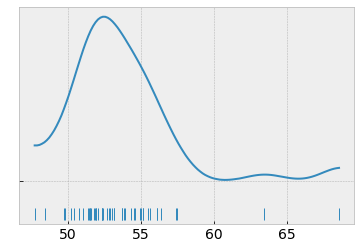

In [4]:
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

The KDE (Kernel Density Estimation) plot of this dataset shows a Gaussian-like distribution, except for two data points that are far away from the mean:

Ignoring the two outlier points for a moment, assume that a Gaussian distribution is a proper description of the data. Since we do not know the mean or the standard deviation, we must set priors for both of them. Therefore, a reasonable model could be:

In [5]:
display(Math(r'\mu \sim U(l,h)')) #a uniform distribution
display(Math(r'\sigma \sim | \ N(0,\sigma_\sigma) \ |'))
display(Math(r'y \sim N(\mu,\sigma)')) #a normal distribution

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Thus, mu comes from a uniform distribution with boundaries l and h, which are the lower and upper bounds, respectively, and sigma comes from a half-normal distribution with a standard deviation of sigma_h. In our model, the data, y,  comes from a Normal distribution with the parameters mu and sigma.

<img src="gmodel.png">

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4402.94draws/s]
/Users/m102417/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2882d0b8>,
      dtype=object)

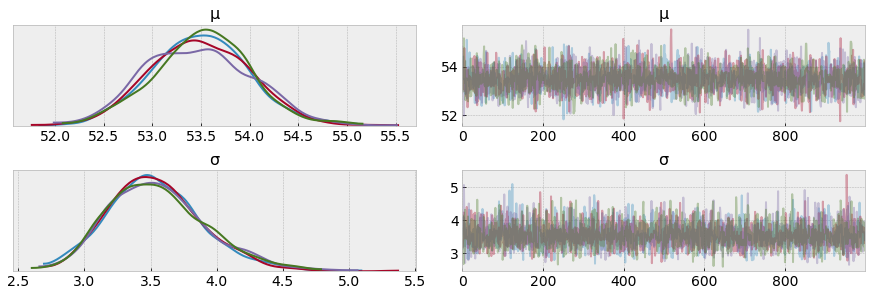

In [6]:
# specify the model
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70) #look at plot above, alternately we could choose lower=0, upper=100
    σ = pm.HalfNormal('σ', sd=10)           # 10 is a LARGE value for the data
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)
az.plot_trace(trace_g)

For this model, the posterior is bi-dimensional, and so the trace above is showing the marginal distributions of each parameter.  

/Users/m102417/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


(<matplotlib.axes._subplots.AxesSubplot at 0x1c28c70c88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2afbab70>)

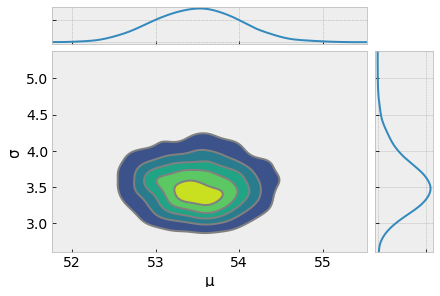

In [7]:
# show the bi-dimentional posterior
az.plot_joint(trace_g, kind='kde', fill_last=False)

In [8]:
az.summary(trace_g)

/Users/m102417/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,53.494,0.511,0.008,0.006,52.522,54.402,3628.0,3625.0,3658.0,2665.0,1.0
σ,3.549,0.363,0.006,0.004,2.909,4.252,3598.0,3551.0,3628.0,2787.0,1.0


NOTE: type \sigma<tab> or \mu<tab> to get funny characters in the notebook

Now that we have computed the posterior, we can use it to simulate data and check how consistent the simulated is data with respect to the observed data.  We generically call this type of comparisons posterior predictive checks, because we are using the posterior to make predictions, and are using those predictions to check the model.

In [9]:
# generate 100 predictions from the posterior, each one of the same size as the data.  
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)

100%|██████████| 100/100 [00:00<00:00, 134.89it/s]


In [10]:
y_pred_g

{'y': array([[56.44553575, 53.01262693, 55.52060198, ..., 53.97123266,
         53.48656236, 53.04817849],
        [52.34772149, 47.76116699, 53.56619062, ..., 57.16641318,
         55.80830866, 56.82528352],
        [55.98735783, 59.06416672, 55.90025431, ..., 49.14917125,
         56.32423165, 59.02275328],
        ...,
        [59.45947844, 47.77904165, 50.43887864, ..., 46.72914354,
         53.21417415, 42.22080419],
        [51.76162381, 58.92184626, 53.59757264, ..., 54.6069011 ,
         52.17958655, 52.47110384],
        [49.34076715, 49.11046294, 44.56378364, ..., 51.11675413,
         57.03773038, 58.30916999]])}

/Users/m102417/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


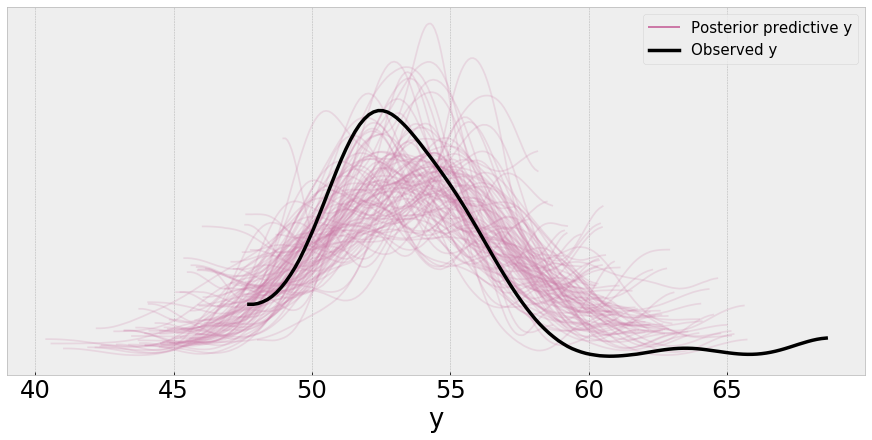

In [11]:
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)

The black line is a KDE of the data and the many semitransparent (magenta) lines are KDEs computed from each one of the 100 posterior predictive samples. The semitransparent (magenta) lines reflect the uncertainty we have about the inferred distribution of the predicted data. Sometimes, when you have very few data points. A plot like this one could show the predicted curves as hairy or wonky; this is due to the way the KDE is implemented in ArviZ. The density is estimated within the actual range of the data passed to the kde function, while outside this range the density is assumed to be zero. While some could reckon this as a bug, I think it's a feature, since it's reflecting a property of the data instead of over-smoothing it.

we can see that the mean of the simulated data is slightly displaced to the right and that the variance seems to be larger for the simulated data than for the actual data. This is a direct consequence of the two observations that are separated from the bulk of the data. Can we use this plot to confidently say that the model is faulty and needs to be changed? Well, as always, the interpretation of the model and its evaluation is context-dependent. Based on my experience for these type of measures and the ways I generally use this data, I would say this model is a reasonable enough representation of the data and useful for most of my analysis.